# A simple, yet complete, tutorial on how use the CCS_fit module to fit two-body interactions

In [300]:
#REMOVE SOME HARD CODING. FOR EXAMPLE: "Ne-Ne" and "Ne" which is used further down.


import numpy as np
from ase.io import read,write
from ase.build import bulk
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt

atom = 'Fe'
sigma = 2.26738
epsilon = 0.70641
N = 2

LJ = bulk(atom, 'bcc', a=2.866)
LJ = LJ * [N, N, N]
calc = LennardJones(sigma=sigma, epsilon=epsilon)
LJ.calc = calc 

Fit_on_forces = True  #Enable/disable option for fitting CCS potential to atomic forces. 



### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [301]:
# CHECK THE RATTLE FUNCTION TO MAKE SURE THAT WE DO NOT GET THE SAME RATTLES EVERYTIME

orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude = 0.02  # 0.02 and disp_steps 5 leads to decieving results!
disp_steps = 5
rounds = 2

trainset_list="file_list" # List of strucutres to include in the data-base (see below)
f = open(trainset_list, "w")
counter = 1
for round in range(rounds):
    for scale in np.linspace(0.95, 1.05, 7):
        new_cell = orig_cell * scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            if nrg < 0:
                xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
                write(xyz_file, rattle_struc)
                print(xyz_file, file=f)
                counter += 1

f.close()
       

### BUILD REFERENCE DATA-BASE

After generating the data, we collect it in an ASE database file. The ``file_list`` is a file containing a list of files to be collected into the data base.

Example of a ``file_list`` file:

    CALCULATED_DATA/S2.xyz
    CALCULATED_DATA/S3.xyz
    CALCULATED_DATA/S4.xyz
    CALCULATED_DATA/S5.xyz
    CALCULATED_DATA/S6.xyz
    CALCULATED_DATA/S7.xyz
    CALCULATED_DATA/S8.xyz
    CALCULATED_DATA/S9.xyz



In [302]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode='CCS', DFT_DB='LJ.db', file_list='file_list', overwrite=True)

    Building data-bases: 100%|██████████| 70/70 [00:21<00:00,  3.33it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [303]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="LJ.db",include_forces=Fit_on_forces)

    Fetching data: 100%|██████████| 70/70 [00:00<00:00, 150.99it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [304]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                f'{atom}-{atom}': {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono"

                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [305]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Fe']
    Applying monotonous constraints for pair:  Fe-Fe
    Merging intervall for pair Fe-Fe. Number of knots reduced from 402 to 328. 
    Condition number is: 1227980086277.9106 ( 328 240180.9979570782 1.955846321087637e-07)


    Finding optimum switch: 100%|██████████| 328/328 [00:11<00:00, 29.60it/s]


    The best switch is (102,) with mse: 0.00014409 
    Final root mean square error in fit:  0.0003047433386026383  (eV/atoms) [NOTE: Only elements specified in Onebody are considered!]


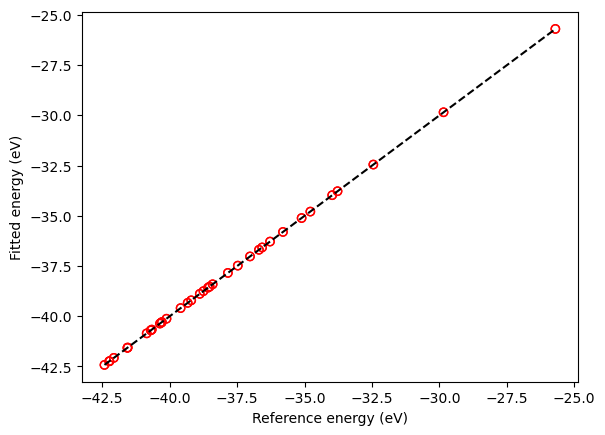

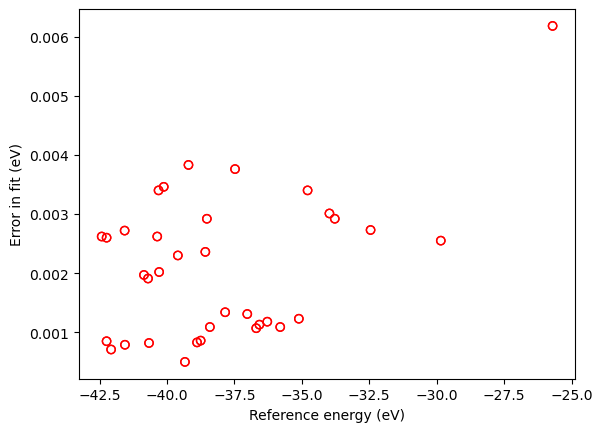

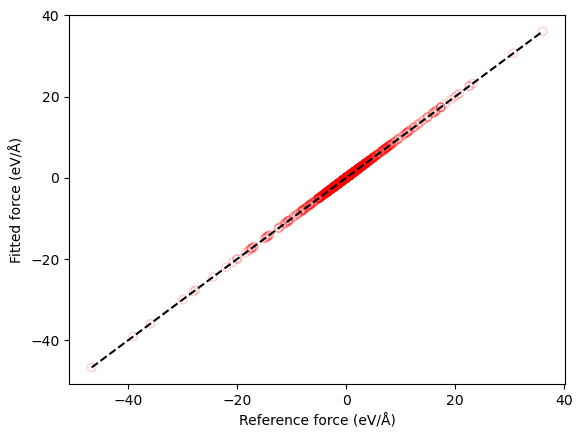

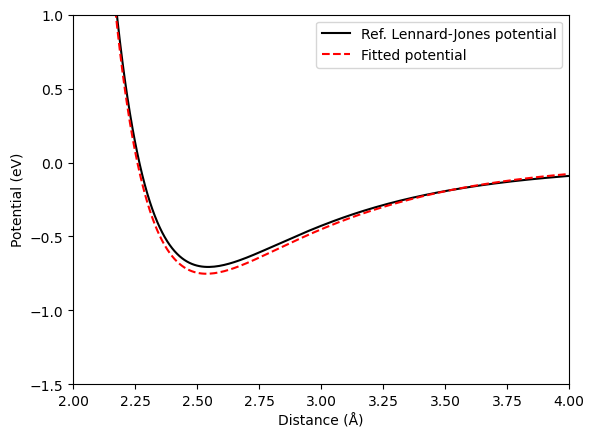

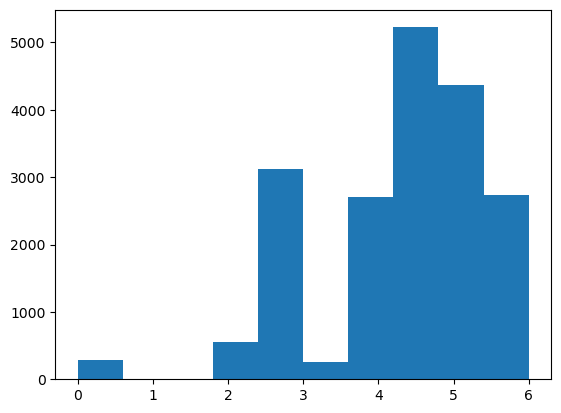

In [306]:
with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

r = np.array(CCS_params["Two_body"][f'{atom}-{atom}']["r"])
e=CCS_params["Two_body"][f'{atom}-{atom}']["spl_a"]
e_LJ = 4 * epsilon*((sigma/ r) ** 12 - (sigma/ r) ** 6)

try:
    err = np.loadtxt("CCS_error.out")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Fitted energy (eV)')
    plt.plot([min(err[:, 0]),max(err[:, 0])],[min(err[:, 0]),max(err[:, 0])], '--', color='black'  )
    plt.scatter(err[:, 0],err[:, 1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:, 0],err[:, 2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

try:
    err_F = np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:, 0]),max(err_F[:, 0])],[min(err_F[:, 0]),max(err_F[:, 0])], '--', color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass


plt.xlim(2, 4)
plt.ylim(-1.5, 1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r, e_LJ, color='black', label="Ref. Lennard-Jones potential")
plt.plot(r, e ,'--', color='red', label="Fitted potential")
plt.legend()
plt.show()

d=[]
for t in training_set["energies"]:
    d.extend(training_set["energies"][t][f'{atom}-{atom}'])

plt.hist(d) #Lägg till x och ylabels
plt.show()


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [307]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="LJ.db")

  0%|          | 0/70 [00:00<?, ?it/s]/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


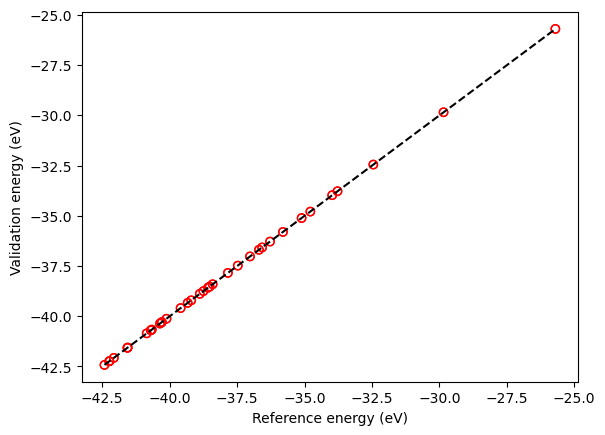

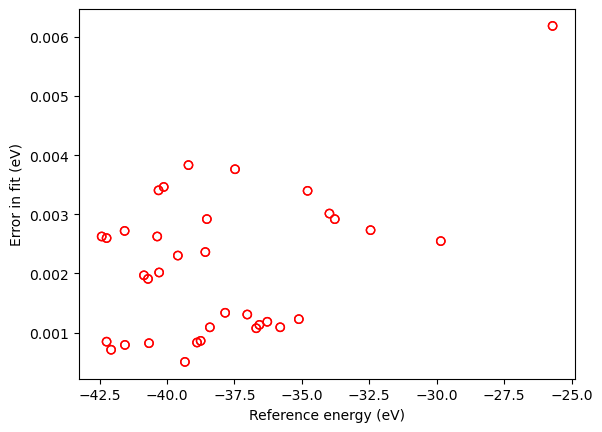

In [308]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Geometry optimization

In [309]:
from ase.optimize import BFGS 
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm

struct = db.connect('LJ.db')
calc = CCS(CCS_params=CCS_params)

for row in tqdm(struct.select(), total=len(struct)):
    structure = row.toatoms()
    structure.calc = calc
    structure.get_forces()
    struct.write(structure, CCS=True)

opt = BFGS(structure, trajectory='opt.traj')
opt.run(fmax=0.05)

  0%|          | 0/70 [00:00<?, ?it/s]/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ase/db/core.py:105: UserWarning: It is best not to use keys (CCS) that are also a chemical formula.  If you do a "db.select('CCS')",you will not find rows with your key.  Instead, you wil get rows containing the atoms in the formula!
  warnings.warn(
100%|██████████| 70/70 [00:19<00:00,  3.51it/s]

      Step     Time          Energy         fmax
BFGS:    0 15:55:19      -35.110715        7.6559
BFGS:    1 15:55:19      -37.078800        2.4546
BFGS:    2 15:55:19      -37.523546        1.1891
BFGS:    3 15:55:19      -37.660793        0.4769
BFGS:    4 15:55:19      -37.673978        0.3942


BFGS:    5 15:55:19      -37.684980        0.2645
BFGS:    6 15:55:19      -37.690103        0.1512
BFGS:    7 15:55:19      -37.692285        0.1633
BFGS:    8 15:55:19      -37.695045        0.2079
BFGS:    9 15:55:19      -37.702727        0.3754
BFGS:   10 15:55:19      -37.718823        0.7666
BFGS:   11 15:55:19      -37.734827        0.6659
BFGS:   12 15:55:19      -37.763677        0.3376
BFGS:   13 15:55:19      -37.734473        0.6551
BFGS:   14 15:55:19      -37.777735        0.1446
BFGS:   15 15:55:19      -37.781467        0.1582
BFGS:   16 15:55:19      -37.782646        0.1354
BFGS:   17 15:55:20      -37.789735        0.2232
BFGS:   18 15:55:20      -37.796850        0.3838
BFGS:   19 15:55:20      -37.807573        0.7046
BFGS:   20 15:55:20      -37.821448        0.4952
BFGS:   21 15:55:20      -37.843866        0.2835
BFGS:   22 15:55:20      -37.854050        0.1517
BFGS:   23 15:55:20      -37.855650        0.1102
BFGS:   24 15:55:20      -37.856442        0.0855


True

### Equation of state

700.1818282228774 GPa


<AxesSubplot: title={'center': 'sj: E: -5.375 eV, V: 11.121 Å$^3$, B: 700.182 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

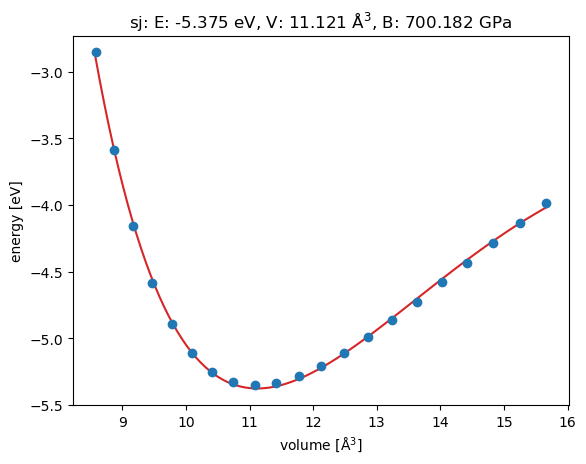

In [310]:
from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.calculators.emt import EMT
from ase.units import kJ
from ase.eos import EquationOfState

# Need GeoOpt for bigger molecules.

a = 2.866  # Lattice constant for BCC Fe
b = a / 2
Fe = Atoms('Fe',
           cell=[(-b, b, b), (b, -b, b), (b, b, -b)], 
           pbc=1,
           calculator=LennardJones(sigma=2.27 , epsilon=0.706))
cell = Fe.get_cell()
traj = Trajectory('Fe.traj', 'w')
for x in np.linspace(0.9, 1.1, 21):
    Fe.set_cell(cell * x, scale_atoms=True)
    cur_nrg = Fe.get_potential_energy()
    traj.write(Fe)

configs = read('Fe.traj@:')

volumes = [Fe.get_volume() for Fe in configs]
energies = [Fe.get_potential_energy() for Fe in configs]
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ *1.0e24, 'GPa')
eos.plot('FeEos.png')  


100.0762017667484 GPa


<AxesSubplot: title={'center': 'sj: E: -0.000 eV, V: 16.776 Å$^3$, B: 100.076 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

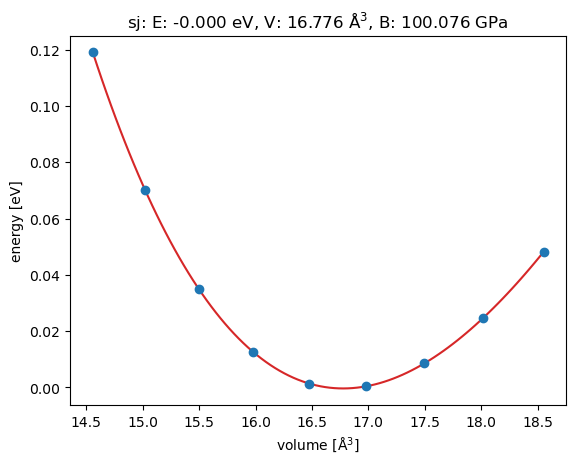

In [311]:
### Do seperate Notebook to fit another round CCS

a = 4.08
b = a / 2
ag = Atoms('Ag',
           cell=[(0, b, b), (b, 0, b), (b, b, 0)],
           pbc=1,
           calculator=EMT()) 
cell = ag.get_cell()
traj = Trajectory('Ag.traj', 'w')
for x in np.linspace(0.95, 1.03, 9):
    ag.set_cell(cell * x, scale_atoms=True)
    ag.get_potential_energy()
    traj.write(ag)

configs = read('Ag.traj@:') 

volumes = [ag.get_volume() for ag in configs]
energies = [ag.get_potential_energy() for ag in configs]
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')
eos.plot('Ag-eos.png')


### Phonon spectra

In [312]:
import os
from phonopy import Phonopy
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.interface.calculator import read_crystal_structure

def setup_model(CCS_params):
    CCS_calc = CCS(CCS_params=CCS_params)
    calcs = [CCS_calc]
    weights = [1]
    calc = np.linalg.solve(calcs, weights)
    return calc

def run_gap(calc, phonon):
    supercells = phonon.get_supercells_with_displacements()
    print('Number of Cells', len(supercells))
    set_of_forces = []
    for scell in supercells:
        cell = Atoms(symbols=scell.get_chemical_symbols(),
                     scaled_positions=scell.get_scaled_positions(),
                     cell=scell.get_cell(),
                     pbc=True)
        cell.set_calculator(calc)
        forces = cell.get_forces()
        drift_force = forces.sum(axis=0)
        for force in forces:
            force -= drift_force / forces.shape[0]
        set_of_forces.append(forces)
    return set_of_forces

def obtain_phonopy_mesh(phonon, mesh):
    phonon.run_mesh(mesh)
    mesh_dict = phonon.get_mesh_dict()
    return mesh_dict['qpoints'], mesh_dict['weights'], mesh_dict['frequencies']

def print_freq_at_G(phonon):
    print('')
    print("[Phonopy] Phonon frequencies at Gamma:")
    for i, freq in enumerate(phonon.get_frequencies((0, 0, 0))):
        print("[Phonopy] =: .5f THz" %  (i + 1, freq)) # THz

def obtain_phonon_dispersion_bands(phonon,bands_ranges,band_resolution=50,band_connection=False):
    bands = []
    for q_start, q_end in bands_ranges:
        band = []
        for i in range(band_resolution + 1):
            band.append(np.array(q_start) + (np.array(q_end) - np.array(q_start)) / band_resolution * i)
        bands.append(band)
    phonon.run_band_structure(bands, is_band_connection=band_connection, with_eigenvectors=True)

    bands_dict = phonon.get_band_structure_dict()
    return (bands_dict['qpoints'],
            bands_dict['distances'],
            bands_dict['frequencies'],
            bands_dict['eigenvectors'])

def run_dos(phonon,mesh):
    phonon.run_mesh(mesh)
    phonon.run_total_dos(use_tetrahedron_method=True)
    dos_dict = phonon.get_total_dos_dict()
    dos = np.array([dos_dict['frequency_points'], dos_dict['total_dos']])
    np.savetxt("TDOS",dos)
    print("[Phonopy] Phonon DOS:")
    phonon.plot_total_dos().savefig("dos.jpg")

def run_pdos(phonon, mesh):
    phonon.run_mesh(mesh, with_eigenvectors=True, is_mesh_symmetry=False)
    phonon.run_projected_dos()
    pdos_dict = phonon.get_projected_dos_dict()
    for i in range(len(pdos_dict['projected_dos'])):
        pdos = np.array([pdos_dict['frequency_points'], pdos_dict['projected_dos'][i]])
        np.savetxt(str(i) + ".pdos", pdos)

def run_thermal(phonon,mesh):
    phonon.run_mesh(mesh)
    phonon.run_thermal_properties(t_step=10, t_max=1700, t_min=0)
    phonon.write_yaml_thermal_properties()
    tp_dict = phonon.get_thermal_properties_dict()
    temperatures = tp_dict['temperatures']
    free_energy = tp_dict['free_energy']
    entropy = tp_dict['entropy']
    heat_capacity = tp_dict['heat_capacity']
    #for t, F, S, cv in zip(temperatures, free_energy, entropy, heat_capacity):
    #    print(("%12.3f " + "%15.7f" * 3) % ( t, F, S, cv ))
    phonon.plot_thermal_properties().show()  

    #calc = setup_model(CCS_params)
    #unitcell = read('@'+str(cells))
    #write('POSCAR', unitcell)
    #cell, _ = read_crystal_structure('POSCAR', interface_mode = 'vasp')
    #N = 3
    #smat=[[N, 0, 0], [0, N, 0], [0, 0, N]]
    #phonon = Phonopy(cell, smat)
    #phonon.generate_displacements(distance=0.02)
    #set_of_forces = run_gap(calc, phonon)
    #phonon.produce_force_constants(forces=set_of_forces)
    #mesh = (20, 20, 20)
    #run_dos(phonon, mesh)
#   #run_pdos(phonon,mesh)
    #run_thermal(phonon, mesh)
    #os.chdir(base_dir"/RUN_SIM/")


#a = 2.866
#unitcell = PhonopyAtoms(symbols=['Fe']*8,
#                        cell=(np.identity(3)*a),
#                        scaled_positions=[[0, 0, 0],
#                        [0, 0.5, 0.5],
#                        [0.5, 0, 0.5],
#                        [0.5, 0.5, 0],
#                        [0.25, 0.25, 0.25],
#                        [0.25, 0.75, 0.75],
#                        [0.75, 0.25, 0.75],
#                        [0.75, 0.75, 0.25]])
#
#phonon = Phonopy(unitcell,
#                 supercell_matrix=[[2, 0, 0], [0, 2, 0], [0, 0, 2]],
#                 primitive_matrix=[[0, 0.5, 0.5],
#                                   [0.5, 0, 0.5],
#                                   [0.5, 0.5, 0]])
#
#phonon.generate_displacements(distance=0.03)
#supercells = phonon.supercells_with_displacements

### Cleaning up

In [313]:
import glob
import itertools as it

def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass

L1 = glob.glob("CALCULATED_DATA/*")
L2 = glob.glob("CCS_*")
L3 = glob.glob("*.traj")
L4 = glob.glob("*.png")
L5 = glob.glob("*.db")

for file in it.chain(L1, L2, L3, L4, L5):
    rm(file)
files = [
    "structures.json",
    "file_list",
    "ccs.spl"    
]
for file in files:
    rm(file)
